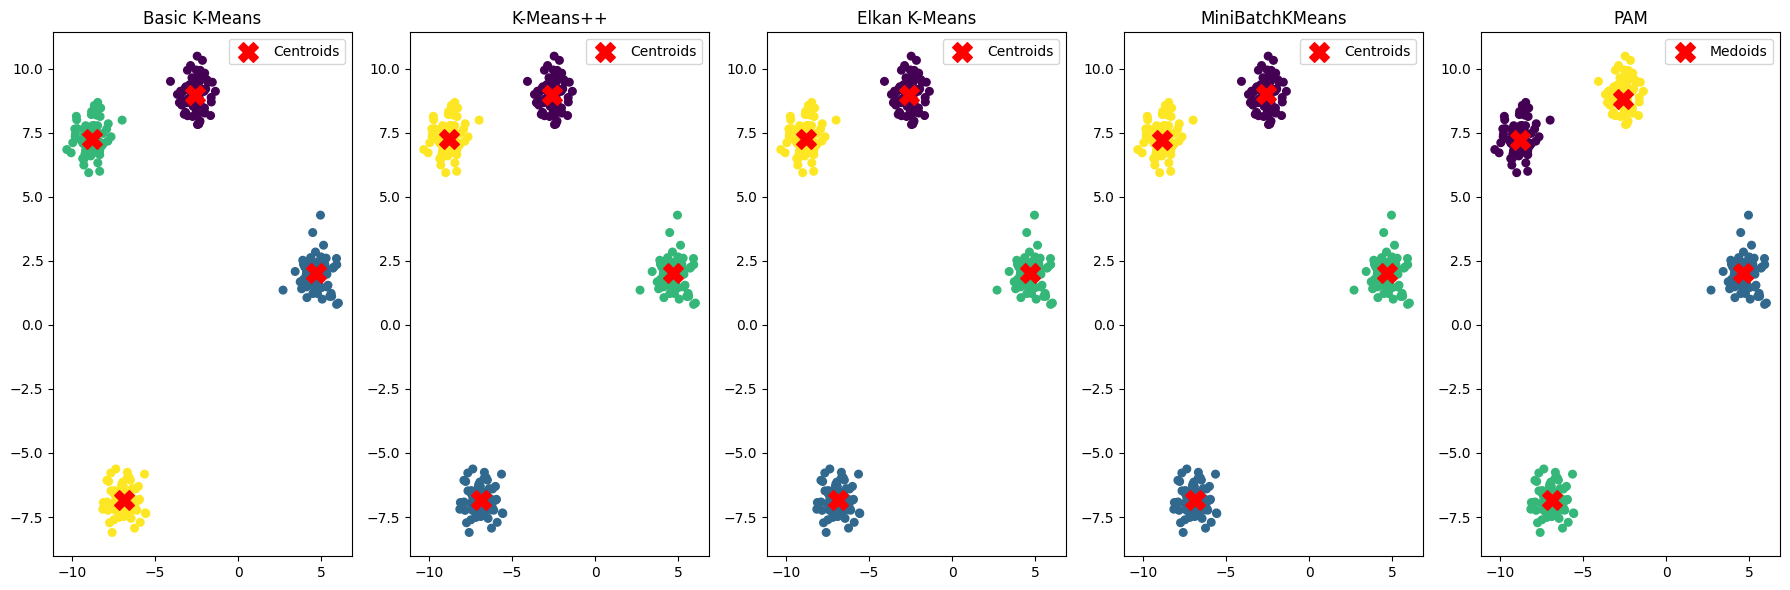

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric, type_metric
from sklearn.cluster import MiniBatchKMeans

# Generate synthetic data
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)

# Basic K-Means, K-Means++ and Elkan K-Means in Scikit-learn
models = {
    "Basic K-Means": KMeans(n_clusters=4, init='random', algorithm='lloyd', random_state=42),
    "K-Means++": KMeans(n_clusters=4, init='k-means++', algorithm='lloyd', random_state=42),
    "Elkan K-Means": KMeans(n_clusters=4, init='k-means++', algorithm='elkan', random_state=42),
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=4, init='k-means++', random_state=42)
}

# PAM clustering using pyclustering
# Initialize medoids using k-means++ initializer
initial_medoids = kmeans_plusplus_initializer(X, 4).initialize(return_index=True)
pam_metric = distance_metric(type_metric.EUCLIDEAN)
models["PAM"] = kmedoids(X, initial_medoids, metric=pam_metric)

# Plot results of each model
fig, axes = plt.subplots(1, len(models), figsize=(18, 6))

for i, (name, model) in enumerate(models.items()):
    if name == "PAM":
        model.process()
        clusters = model.get_clusters()
        y_pred = np.zeros(X.shape[0])
        for cluster_id, cluster_indices in enumerate(clusters):
            y_pred[cluster_indices] = cluster_id
        centers = X[model.get_medoids()]
    else:
        y_pred = model.fit_predict(X)
        centers = model.cluster_centers_

    axes[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=30)
    axes[i].scatter(centers[:, 0], centers[:, 1], s=200, c='red', marker='X', label='Centroids' if name != "PAM" else 'Medoids')
    axes[i].set_title(name)
    axes[i].legend()

plt.tight_layout()
plt.show()


以下是几种基于质心的聚类算法的特点、适用场景以及优缺点的详细介绍：

---

### 1. **Basic K-Means（基础 K-Means）**
   - **特点**：
     - 使用随机初始化质心的位置。
     - 通过迭代最小化簇内平方误差 (Inertia)。
   - **适用场景**：
     - 数据分布呈现球形或均匀的簇结构。
     - 希望快速探索数据的大致分布。
   - **优点**：
     - 算法简单，易于实现。
     - 适合小规模数据。
   - **缺点**：
     - 对初始质心敏感，可能陷入局部最优。
     - 对噪声点和离群值敏感。

---

### 2. **K-Means++**
   - **特点**：
     - 使用 K-Means++ 初始化策略，选择距离已有质心较远的数据点作为新的质心。
     - 相比随机初始化，提高收敛速度和精度。
   - **适用场景**：
     - 数据簇结构复杂但仍呈球形分布。
     - 需要比基础 K-Means 更稳定和准确的结果。
   - **优点**：
     - 提高质心的初始选择质量，减少迭代次数。
     - 通常能找到更接近全局最优的解。
   - **缺点**：
     - 相比基础 K-Means 增加了初始化计算的时间开销。

---

### 3. **Elkan K-Means**
   - **特点**：
     - 使用三角不等式优化距离计算，减少不必要的点到质心的距离计算。
     - 提升算法效率，特别是在高维空间。
   - **适用场景**：
     - 数据维度较高（通常高于 10 维）的场景。
     - 需要提高计算效率的大规模数据。
   - **优点**：
     - 计算速度较快。
     - 减少了不必要的计算。
   - **缺点**：
     - 仅适用于欧几里得距离。

---

### 4. **MiniBatchKMeans**
   - **特点**：
     - 使用小批量数据更新质心，加快收敛速度。
     - 适合处理大规模数据集。
   - **适用场景**：
     - 数据集非常大，内存无法加载全部数据。
     - 需要在有限时间内完成聚类。
   - **优点**：
     - 计算速度快，占用内存较小。
     - 能处理大规模数据。
   - **缺点**：
     - 可能略微降低聚类结果的精度。
     - 对批量大小敏感。

---

### 5. **PAM（Partitioning Around Medoids）**
   - **特点**：
     - 使用数据点本身作为代表点（Medoids），替代质心。
     - 基于中位数优化距离计算。
   - **适用场景**：
     - 数据分布不规则或非球形。
     - 需要对离群点和噪声更鲁棒的算法。
   - **优点**：
     - 对离群点和噪声不敏感。
     - 能处理非欧几里得距离（通过自定义距离矩阵）。
   - **缺点**：
     - 计算复杂度较高，适合中小规模数据。
     - 对大规模数据效率较低。

---

### 总结

| 方法              | 初始敏感性 | 噪声敏感性 | 适用数据规模 | 适用距离 | 计算复杂度 | 收敛速度 | 适用场景                     |
|-------------------|------------|------------|--------------|----------|------------|----------|-----------------------------|
| Basic K-Means     | 高          | 高          | 小            | 欧几里得  | 低          | 中        | 球形簇，小规模数据           |
| K-Means++         | 中          | 高          | 中            | 欧几里得  | 中          | 快        | 球形簇，中等复杂度数据       |
| Elkan K-Means     | 中          | 高          | 中/大         | 欧几里得  | 中          | 快        | 高维数据，球形簇             |
| MiniBatchKMeans   | 中          | 高          | 大            | 欧几里得  | 低          | 快        | 大规模数据，内存受限场景     |
| PAM               | 低          | 低          | 小/中         | 自定义    | 高          | 中        | 非规则簇，鲁棒性需求场景     |

